# Sourcing and Analyzing Time Series Data 

1 Importing Your Libraries and Data
2 Clean Data
3 Decompose Data Components
4 Checking for Stationarity
5 Difference Non Stationary Data
6 Difference Again
7 Keep Differencing 

# 1 Importing Your Libraries and Data 

In [1]:
# import libraries
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os
import warnings

warnings.filterwarnings("ignore") 

plt.style.use('fivethirtyeight') 

In [2]:
# configure API key
quandl.ApiConfig.api_key = 'DDmXDUVk7G7EnCt2EWam'

In [3]:
# import US Treasury Real Long Term Rates variable 
data = quandl.get('USTREASURY/REALLONGTERM')

In [4]:
# check 
data.head(10)

,LT Real Average (>10Yrs)
Date,
2000-01-03,4.30
2000-01-04,4.30
2000-01-05,4.30
2000-01-06,4.32
2000-01-07,4.32
2000-01-10,4.34
2000-01-11,4.35
2000-01-12,4.34
2000-01-13,4.33


In [5]:
# check shape
data.shape

(5686, 1)

In [6]:
# check columns
data.columns

Index(['LT Real Average (>10Yrs)'], dtype='object')

In [7]:
# plot data using matplotlib
plt.figure(figsize=(15,5), dpi=100)

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

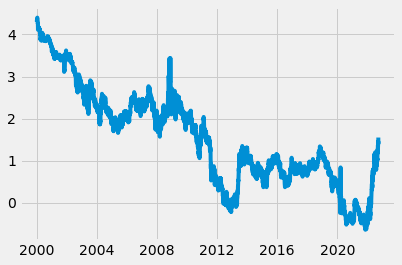

In [8]:
plt.plot(data)

I do not believe I need to subset the data because these are the real updated treasury rates through.  Although there would be the spike with covid, we are including the 2008 spike as well.  I will leave the data as is.  The result of the plot makes sense, as there would be a spike after 2020 into current.

# 2 Clean Data

In [9]:
# check for missing values
data.isnull().sum()

LT Real Average (>10Yrs)    0
dtype: int64

In [10]:
# check for Duplicates 
dups = data.duplicated()
dups.sum()

5207

In [11]:
# drop duplicates 
dataclean = data.drop_duplicates()

In [12]:
# check shape
dataclean.shape

(479, 1)

# 3 Decompose Data Components

In [13]:
dataclean.sort_index(inplace=True)

<AxesSubplot:xlabel='Date'>

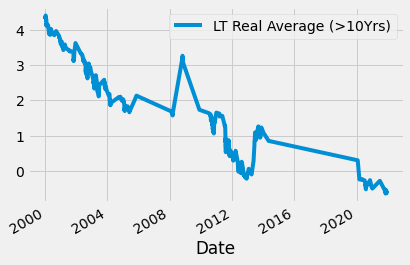

In [14]:
dataclean.plot()

In [15]:
# reset index to change column to date time
data2 = dataclean.reset_index()

In [16]:
# check
data2.head(10)

,Date,LT Real Average (>10Yrs)
0,2000-01-03,4.30
1,2000-01-06,4.32
2,2000-01-10,4.34
3,2000-01-11,4.35
4,2000-01-13,4.33
5,2000-01-14,4.38
6,2000-01-18,4.40
7,2000-01-20,4.39
8,2000-01-21,4.37
9,2000-01-24,4.36


In [17]:
# chenge to datetime
data2['Date'] = pd.to_datetime(data2['Date'], yearfirst = True)

In [18]:
# change back to index column
from datetime import datetime

data2['datetime'] = pd.to_datetime(data2['Date']) # Create a datetime column from "Date.""
data2 = data2.set_index('datetime') # Set the datetime as the index of the dataframe.
data2.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data2.head()

,LT Real Average (>10Yrs)
datetime,
2000-01-03,4.30
2000-01-06,4.32
2000-01-10,4.34
2000-01-11,4.35
2000-01-13,4.33


In [21]:
# import rcParams
from pylab import rcParams

<function matplotlib.pyplot.show(close=None, block=None)>

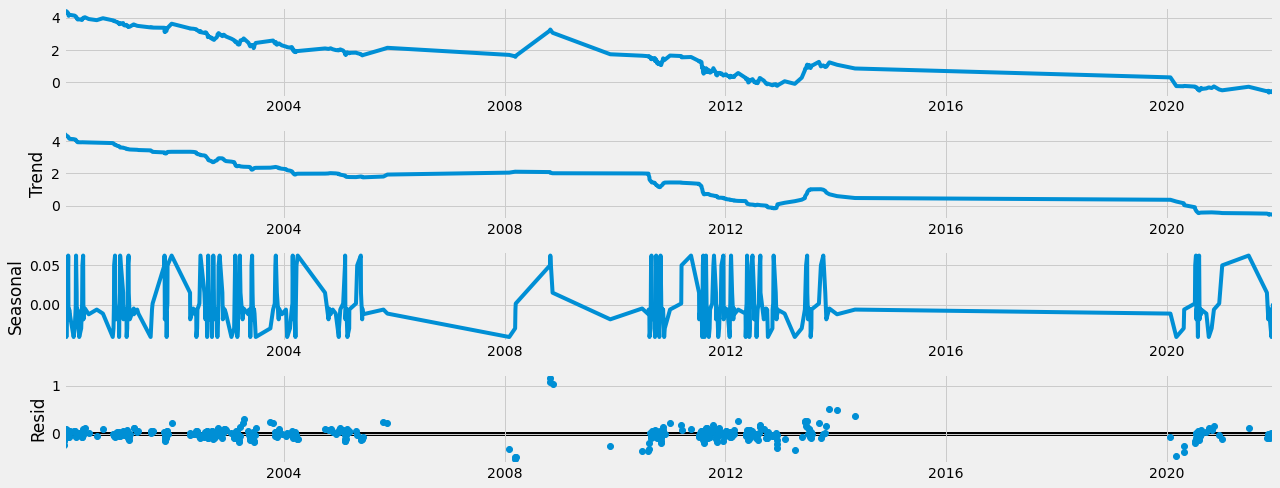

In [26]:
# decompress
rcParams['figure.figsize'] = 18, 7
decomposition = sm.tsa.seasonal_decompose(data2, model='additive', freq=12, extrapolate_trend = 12)
fig = decomposition.plot()
plt.show

I believe that the level and trend appear to be similar in this decompression.  This means that the data is smooth enough for usage. The trend decreases until around 2005 and then gradually increases until around 2011, dropping rabidly and then remaining the same until around 2021.  There is some seasonality because my curve is not flat.  There is noise around the points in the data where the trend fluctuates greatly.  

# 4 Checking for Stationarity 

In [29]:
# test for stationarity
from statsmodels.tsa.stattools import adfuller
def dickey_fuller(timeseries): 
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

dickey_fuller(data2['LT Real Average (>10Yrs)'])

Dickey-Fuller Stationarity test:
Test Statistic                  -0.916528
p-value                          0.782481
Number of Lags Used              4.000000
Number of Observations Used    474.000000
Critical Value (1%)             -3.444221
Critical Value (5%)             -2.867657
Critical Value (10%)            -2.570028
dtype: float64


based on the values above, the data I am using is non stationary and will need some work before forecasting. I cannot reject the null hypothesis. 

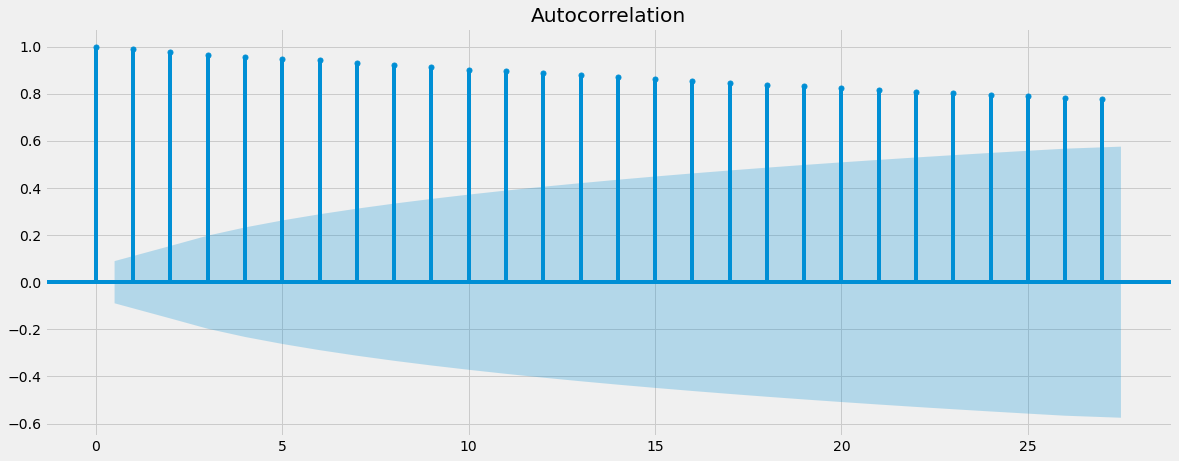

In [30]:
# autocorrealtion test
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(data2)
plt.show()

The lines above the confidence interval confirm that my data is not stationary. 

# 5 Difference Non Stationary Data

In [31]:
# difference
data_diff = data2 - data2.shift(1)

In [32]:
# remove any missing values 
data_diff.dropna(inplace = True)

In [33]:
# check
data_diff.head()

,LT Real Average (>10Yrs)
datetime,
2000-01-06,0.02
2000-01-10,0.02
2000-01-11,0.01
2000-01-13,-0.02
2000-01-14,0.05


In [34]:
# check
data_diff.columns

Index(['LT Real Average (>10Yrs)'], dtype='object')

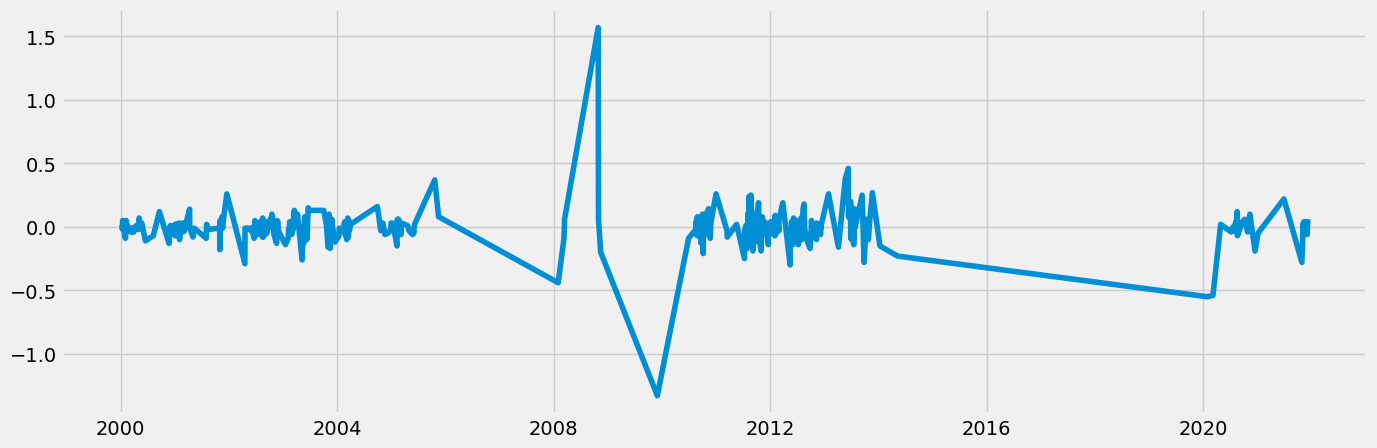

In [35]:
# check out what it did to the curve
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [36]:
# check dickey_fuller
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -1.436649e+01
p-value                        9.652888e-27
Number of Lags Used            3.000000e+00
Number of Observations Used    4.740000e+02
Critical Value (1%)           -3.444221e+00
Critical Value (5%)           -2.867657e+00
Critical Value (10%)          -2.570028e+00
dtype: float64


# 6 Difference Again

In [37]:
# it is not stationary so I will try again
data_diff2 = data_diff - data_diff.shift(1)

In [41]:
# drop any nans
data_diff2.dropna(inplace = True)

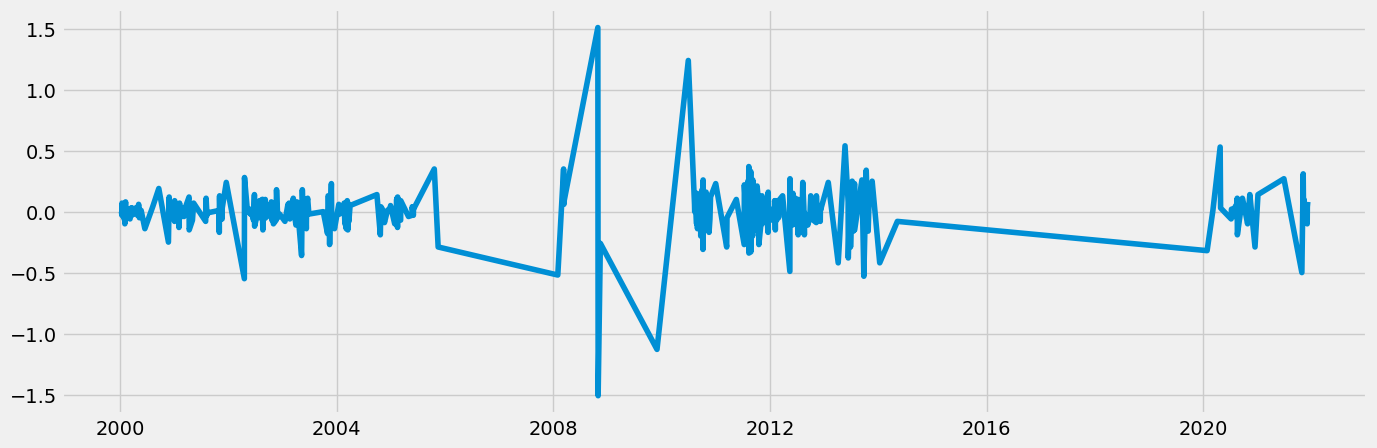

In [42]:
# see what happened to the new curve
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff2)

In [43]:
# check dickey fuller again
dickey_fuller(data_diff2)

Dickey-Fuller Stationarity test:
Test Statistic                -9.484950e+00
p-value                        3.784655e-16
Number of Lags Used            1.600000e+01
Number of Observations Used    4.600000e+02
Critical Value (1%)           -3.444646e+00
Critical Value (5%)           -2.867844e+00
Critical Value (10%)          -2.570128e+00
dtype: float64


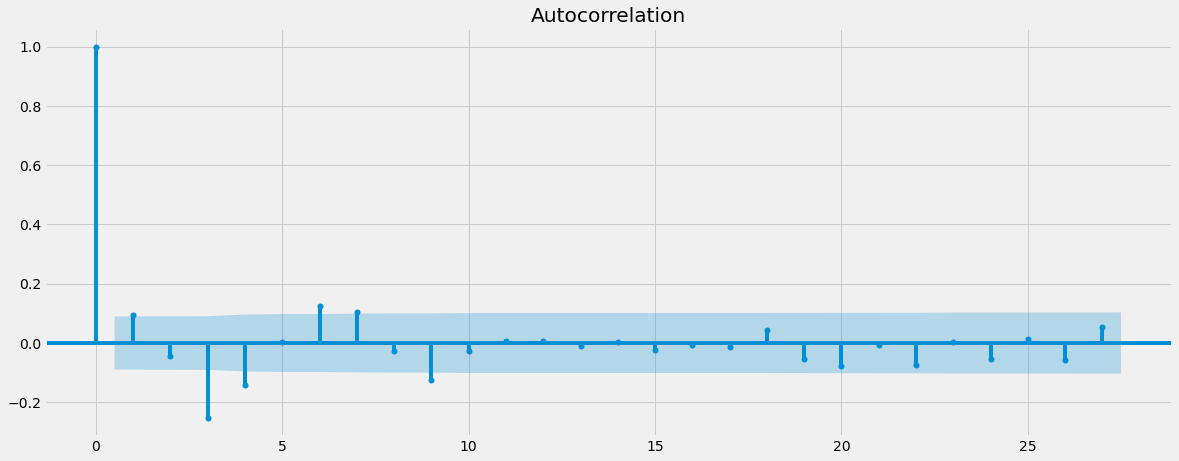

In [44]:
# autocorrealtion test
plot_acf(data_diff)
plt.show()

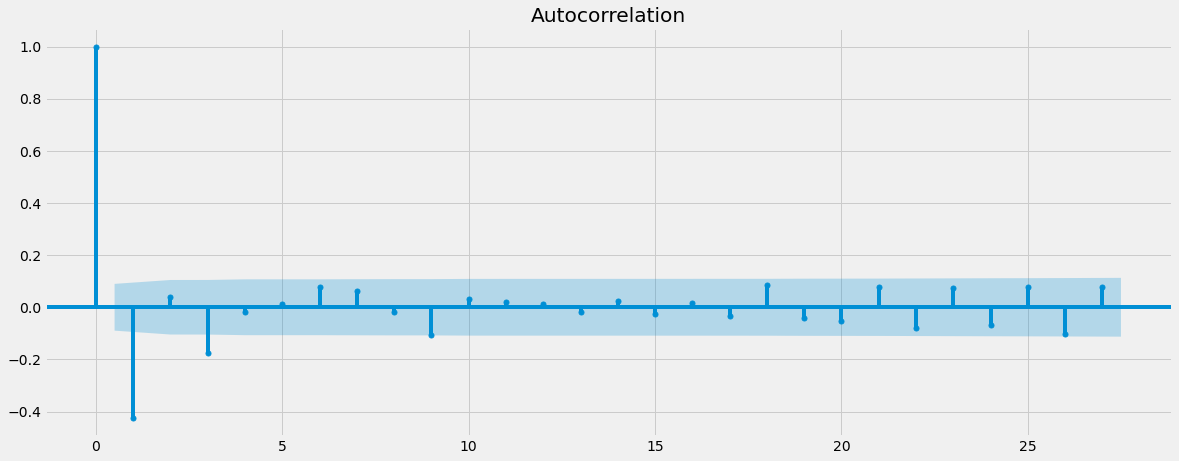

In [45]:
# autocorrealtion test
plot_acf(data_diff2)
plt.show()

# 7 Keep Differencing

In [46]:
# it is not stationary so I will try again
data_diff3 = data_diff2 - data_diff2.shift(1)

In [47]:
# drop any nans
data_diff3.dropna(inplace = True)

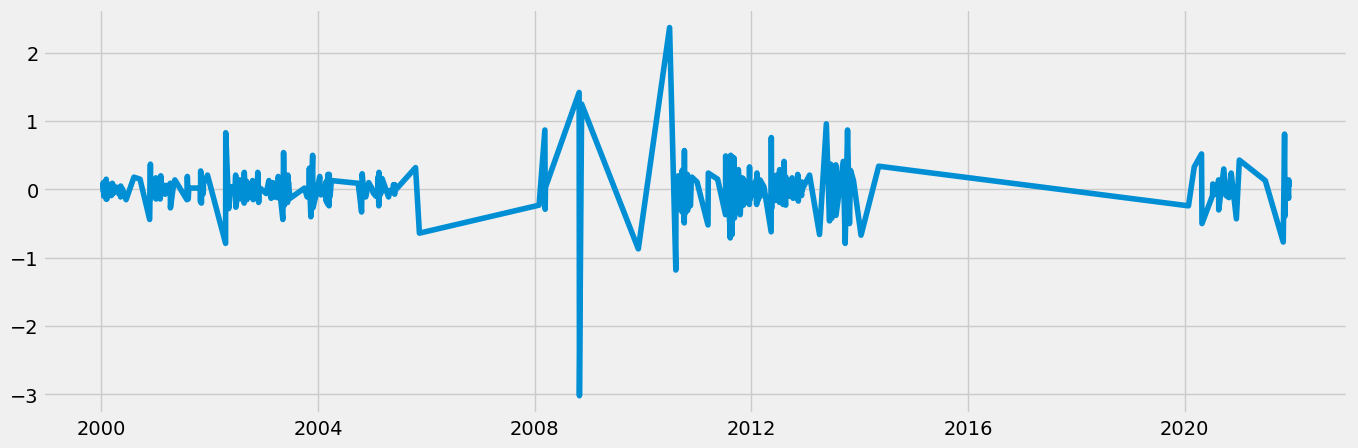

In [48]:
# see what happened to the new curve
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff3)

In [49]:
# check dickey fuller again
dickey_fuller(data_diff3)

Dickey-Fuller Stationarity test:
Test Statistic                -1.209373e+01
p-value                        2.093789e-22
Number of Lags Used            1.700000e+01
Number of Observations Used    4.580000e+02
Critical Value (1%)           -3.444709e+00
Critical Value (5%)           -2.867871e+00
Critical Value (10%)          -2.570142e+00
dtype: float64


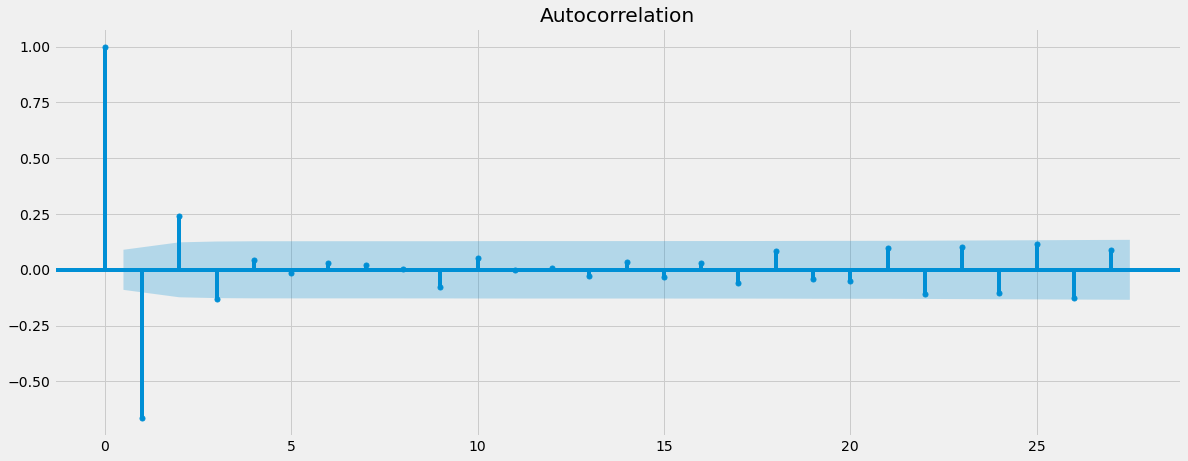

In [50]:
# autocorrealtion test
plot_acf(data_diff3)
plt.show()